In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import layers

In [2]:
!nvidia-smi

Wed Aug 31 08:59:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/Illalla/helper_functions_for_tf/main/helper_functions.py

In [4]:
from helper_functions import *

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('face-mask-detection.zip')
zip_ref.extractall()
zip_ref.close()

In [8]:
walk_dir('/content/Dataset')

There are 3 directories and 0 files in /content/Dataset.
There are 0 directories and 2994 files in /content/Dataset/mask_weared_incorrect.
There are 0 directories and 2994 files in /content/Dataset/without_mask.
There are 0 directories and 2994 files in /content/Dataset/with_mask.


In [9]:
import os
import random

def plot_random_image(filepath):
  images_list = os.listdir(filepath)
  image = plt.imread(f'{filepath}/{random.sample(images_list, 1)[0]}')
  plt.imshow(image)
  plt.title(f'Shape={image.shape}')
  plt.axis(False)

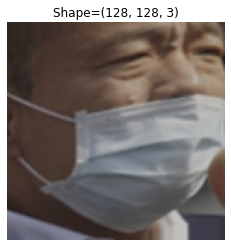

In [10]:
plot_random_image('/content/Dataset/mask_weared_incorrect')

In [11]:
for category in os.listdir('/content/Dataset'):
  os.makedirs(f'/content/data/train/{category}')
  os.makedirs(f'/content/data/test/{category}')
  category_files = os.listdir('/content/Dataset/'+category)
  test_split = int(0.2*len(category_files))
  test_data = random.sample(category_files, test_split)
  for file in test_data:
    os.replace(f'/content/Dataset/{category}/{file}', f'/content/data/test/{category}/{file}')
  os.rename(f'/content/Dataset/{category}', f'/content/data/train/{category}')

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory('/content/data/train',
                                                         image_size=(128, 128),
                                                         label_mode='categorical',
                                                         shuffle=True,
                                                         seed=5).prefetch(tf.data.AUTOTUNE)
test_data = tf.keras.utils.image_dataset_from_directory('/content/data/test',
                                                        image_size=(128, 128),
                                                        label_mode='categorical',
                                                        shuffle=False,
                                                        seed=5).prefetch(tf.data.AUTOTUNE)

Found 7188 files belonging to 3 classes.
Found 1794 files belonging to 3 classes.


In [13]:
model_0 = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3), dtype=tf.float32),
    layers.Rescaling(255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 10,243
Trainable params: 10,243
Non-trainable params: 0
____________________________________________________

In [14]:
history_0 = model_0.fit(train_data,
                        validation_data=test_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(test_data),
                        callbacks=[create_tb_callback('model_0', 'experiments')])

Epoch 1/5
225/225 [==============================] - 22s 39ms/step - loss: 118.4703 - accuracy: 0.5536 - val_loss: 84.9657 - val_accuracy: 0.5396
Epoch 2/5
225/225 [==============================] - 8s 36ms/step - loss: 54.9684 - accuracy: 0.6000 - val_loss: 70.8084 - val_accuracy: 0.5886
Epoch 3/5
225/225 [==============================] - 8s 37ms/step - loss: 51.1290 - accuracy: 0.6078 - val_loss: 21.7584 - val_accuracy: 0.7402
Epoch 4/5
225/225 [==============================] - 9s 38ms/step - loss: 32.1927 - accuracy: 0.6244 - val_loss: 22.7085 - val_accuracy: 0.6098
Epoch 5/5
225/225 [==============================] - 9s 39ms/step - loss: 20.2623 - accuracy: 0.6455 - val_loss: 16.1916 - val_accuracy: 0.6343


In [15]:
model_0.evaluate(test_data)

57/57 [==============================] - 1s 23ms/step - loss: 16.1916 - accuracy: 0.6343


[16.191627502441406, 0.6343366503715515]

In [16]:
test_labels = []
for images, labels in test_data.unbatch():
  test_labels.append(labels.numpy().argmax())

In [17]:
test_labels[:5]

[0, 0, 0, 0, 0]

In [18]:
test_labels.count(0), test_labels.count(1), test_labels.count(2)

(598, 598, 598)

In [19]:
tf.argmax(tf.round(model_0.predict(test_data)), axis=1)

<tf.Tensor: shape=(1794,), dtype=int64, numpy=array([1, 0, 1, ..., 2, 2, 2])>

In [20]:
model_0_preds = tf.argmax(tf.round(model_0.predict(test_data)), axis=1).numpy()
model_0_preds[:2]

array([1, 0])

In [21]:
classification_scores(test_labels, model_0_preds)

Accuracy: 0.6343366778149386
Precision: 0.845758623132478
Recall: 0.6343366778149386
F1_score: 0.7058040068773415


In [22]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3), dtype=tf.float32),
    layers.Rescaling(255),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.3),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])


model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 dropout (Dropout)           (None, 124, 124, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        18464     
                                                      

In [23]:
history_1 = model_1.fit(train_data,
                        validation_data=test_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_steps=len(test_data),
                        callbacks=[create_tb_callback('model_1', 'experiments')])

Epoch 1/5
225/225 [==============================] - 18s 70ms/step - loss: 41.9084 - accuracy: 0.5437 - val_loss: 0.9194 - val_accuracy: 0.5903
Epoch 2/5
225/225 [==============================] - 17s 76ms/step - loss: 0.8972 - accuracy: 0.6114 - val_loss: 0.8464 - val_accuracy: 0.6204
Epoch 3/5
225/225 [==============================] - 16s 71ms/step - loss: 0.8177 - accuracy: 0.6400 - val_loss: 0.7937 - val_accuracy: 0.6505
Epoch 4/5
225/225 [==============================] - 16s 68ms/step - loss: 0.7649 - accuracy: 0.6635 - val_loss: 0.7511 - val_accuracy: 0.6672
Epoch 5/5
225/225 [==============================] - 15s 66ms/step - loss: 0.7315 - accuracy: 0.6778 - val_loss: 0.7267 - val_accuracy: 0.6851


In [24]:
data_augmentation_layer = tf.keras.Sequential([
                                               tf.keras.layers.RandomRotation(0.2),
                                               tf.keras.layers.RandomFlip(mode='horizontal'),
                                               tf.keras.layers.RandomWidth(0.05),
                                               tf.keras.layers.RandomWidth(0.05),
                                               tf.keras.layers.RandomZoom(0.05),                                               
], name='data_aug_layer')

In [25]:
model_2 = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Rescaling(255),
    data_augmentation_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.2),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.4),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')
])

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_2 = model_2.fit(train_data,
            epochs=5,
            validation_data=test_data,
            steps_per_epoch=len(train_data),
            validation_steps=len(test_data),
            callbacks=[create_tb_callback('model_2', 'experiments')])

Epoch 1/5
225/225 [==============================] - 40s 161ms/step - loss: 24.4462 - accuracy: 0.5138 - val_loss: 1.1695 - val_accuracy: 0.3478
Epoch 2/5
225/225 [==============================] - 21s 92ms/step - loss: 0.6831 - accuracy: 0.6821 - val_loss: 1.0748 - val_accuracy: 0.4526
Epoch 3/5
225/225 [==============================] - 17s 76ms/step - loss: 0.6174 - accuracy: 0.7433 - val_loss: 0.8931 - val_accuracy: 0.4298
Epoch 4/5
225/225 [==============================] - 18s 77ms/step - loss: 0.5864 - accuracy: 0.7643 - val_loss: 0.9259 - val_accuracy: 0.4532
Epoch 5/5
225/225 [==============================] - 17s 73ms/step - loss: 0.5464 - accuracy: 0.7905 - val_loss: 0.7921 - val_accuracy: 0.5262


In [29]:
import tensorflow_hub as hub
model_3 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/adityakane2001/regnety800mf_classification/1", input_shape=(128, 128, 3), trainable=False),
    layers.Dense(3, activation='softmax')
])

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_3 = model_3.fit(train_data,
            epochs=5,
            validation_data=test_data,
            steps_per_epoch=len(train_data),
            validation_steps=len(test_data),
            callbacks=[create_tb_callback('model_3', 'experiments')])

Epoch 1/5
225/225 [==============================] - 17s 53ms/step - loss: 1.1943 - accuracy: 0.6281 - val_loss: 0.6618 - val_accuracy: 0.7441
Epoch 2/5
225/225 [==============================] - 11s 50ms/step - loss: 0.4178 - accuracy: 0.8382 - val_loss: 0.4351 - val_accuracy: 0.8233
Epoch 3/5
225/225 [==============================] - 11s 50ms/step - loss: 0.3059 - accuracy: 0.8862 - val_loss: 0.2104 - val_accuracy: 0.9253
Epoch 4/5
225/225 [==============================] - 13s 55ms/step - loss: 0.2263 - accuracy: 0.9149 - val_loss: 0.3239 - val_accuracy: 0.8802
Epoch 5/5
225/225 [==============================] - 13s 55ms/step - loss: 0.2675 - accuracy: 0.9004 - val_loss: 0.2855 - val_accuracy: 0.9086


In [30]:
model_3.trainable = True
for layer in model_3.layers[:-5]:
  model_3.trainable = False
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['accuracy'])
history_3_fine_tuned = model_3.fit(train_data,
            epochs=10,
            validation_data=test_data,
            initial_epoch=history_3.epoch[-1],
            steps_per_epoch=len(train_data),
            validation_steps=len(test_data),
            callbacks=[create_tb_callback('model_3_fine_tuned', 'experiments')])

Epoch 5/10
225/225 [==============================] - 57s 194ms/step - loss: 0.4797 - accuracy: 0.8388 - val_loss: 0.1826 - val_accuracy: 0.9348
Epoch 6/10
225/225 [==============================] - 43s 189ms/step - loss: 0.1306 - accuracy: 0.9591 - val_loss: 0.0920 - val_accuracy: 0.9710
Epoch 7/10
225/225 [==============================] - 42s 187ms/step - loss: 0.0801 - accuracy: 0.9762 - val_loss: 0.0636 - val_accuracy: 0.9777
Epoch 8/10
225/225 [==============================] - 42s 186ms/step - loss: 0.0556 - accuracy: 0.9836 - val_loss: 0.0487 - val_accuracy: 0.9844
Epoch 9/10
225/225 [==============================] - 42s 185ms/step - loss: 0.0369 - accuracy: 0.9898 - val_loss: 0.0356 - val_accuracy: 0.9894
Epoch 10/10
225/225 [==============================] - 42s 186ms/step - loss: 0.0274 - accuracy: 0.9940 - val_loss: 0.0291 - val_accuracy: 0.9916


In [31]:
model_3_preds = tf.argmax(tf.round(model_3.predict(test_data)), axis=1).numpy()
classification_scores(test_labels, model_3_preds)

Accuracy: 0.9916387959866221
Precision: 0.991712580348944
Recall: 0.9916387959866221
F1_score: 0.9916445820949821


In [32]:
#model_3.save('maskmodel.h5')